# Generate Face Embeddings from Video Frames using Deep Learning

### Notebook Overview

This notebook is part of a larger **face recognition pipeline**, and focuses on generating **face embeddings** from video data using deep learning models. Specifically, we use **MTCNN** for face detection and alignment, and **InceptionResnetV1 (FaceNet)** for generating 512-dimensional facial embeddings.

---

### 🎯 Objective

Our goal is to:

- Detect and extract high-quality face crops from video frames.
- Group similar faces using **unsupervised clustering (KMeans)**.
- Manually label each group for supervised learning downstream.
- Generate average embeddings (face "imprints") per identity class.
- Save embeddings for use in recognition or classification systems.

In [27]:
import os
import sys
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import platform
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

In [2]:
# Print versions
print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"OpenCV: {cv2.__version__}")

Python: 3.11.0
Torch: 2.2.2+cu121
Torchvision: 0.17.2+cu121
OpenCV: 4.10.0


In [3]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Device Configuration

We’ll use GPU if available for faster face detection and embedding computation.


In [4]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation Device: {device}")


Computation Device: cuda


## Step 1: Extract Frames with Exactly One Face

As we already have the video frames extracted into `video_data/extracted_frames/`.
Next, we use MTCNN to filter out only those frames that contain **exactly one face**.
This ensures higher embedding quality and avoids ambiguous face clustering/recognition later on.

In [16]:
frames_dir = Path("video_data/extracted_frames")
single_face_dir = Path("single_face_frames")
single_face_dir.mkdir(exist_ok=True, parents=True)

mtcnn = MTCNN(device=device, keep_all=True, post_process=True)

for frame_path in sorted(frames_dir.iterdir()):
    img = Image.open(frame_path).convert("RGB")
    faces_list = mtcnn(img)
    faces = faces_list if faces_list is not None else []
    if len(faces) == 1:
        save_path = single_face_dir / frame_path.name
        shutil.copy(frame_path, save_path)

print(f"Done! Frames with one face saved to: {single_face_dir}")


Done! Frames with one face saved to: single_face_frames


In [19]:
# Count of single-face frames
print(f"Total frames with single face: {len(list(single_face_dir.glob('*.jpg')))}")


Total frames with single face: 1514


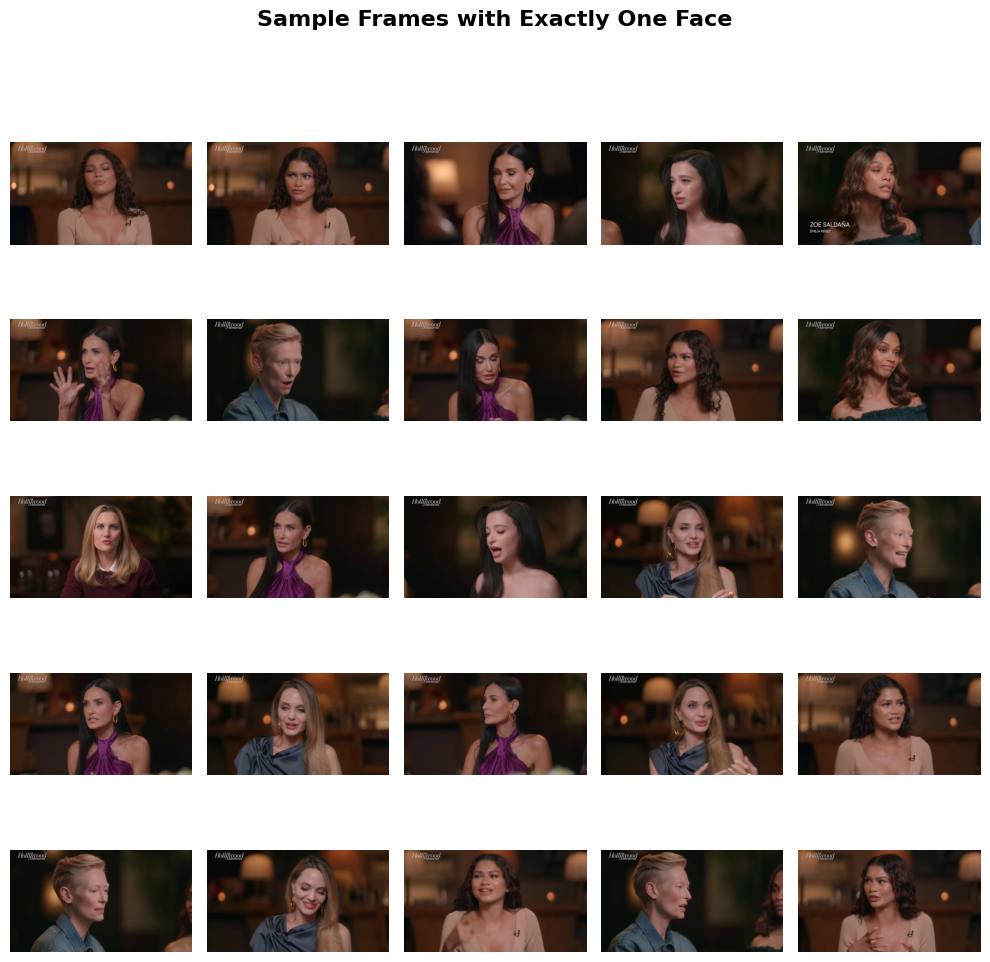

In [6]:
sample_paths = list(single_face_dir.glob("*.jpg"))
sample_paths = random.sample(sample_paths, min(25, len(sample_paths)))

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Sample Frames with Exactly One Face", fontsize=16, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.02, wspace=0.02)  # Tight spacing

# Display each image
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
for ax in axes.flatten()[len(sample_paths):]:
    ax.axis("off")

plt.tight_layout()
plt.show();


## Step 2: Clustering Faces Based on Visual Similarity

We now use a pre-trained FaceNet model (`InceptionResnetV1`) to generate **face embeddings** and apply **KMeans clustering** to group similar faces.

We know that 6 unique faces are available in the dataset.


In [17]:
output_dir = Path("clustered_faces")
output_dir.mkdir(exist_ok=True, parents=True)
single_face_dir = Path("single_face_frames")

# Path to the local weights file
local_weights_path = '20180402-114759-vggface2.pt'

mtcnn = MTCNN(device=device, post_process=True)
# Load the model with local weights
state_dict = torch.load(local_weights_path, map_location=device)
resnet = InceptionResnetV1(classify=False, pretrained=None)
missing, unexpected = resnet.load_state_dict(state_dict, strict=False)
resnet.eval()
resnet = resnet.to(device)

embeddings = []
image_paths = []

for img_path in sorted(single_face_dir.iterdir()):
    img = Image.open(img_path).convert("RGB")
    face = mtcnn(img)
    if face is not None:
        face = face.to(device)
        embedding = resnet(face.unsqueeze(0)).detach().cpu().numpy()
        embeddings.append(embedding[0])
        image_paths.append(img_path)

embeddings = np.array(embeddings)

kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(embeddings)

score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {score:.2f}")

for label, img_path in zip(labels, image_paths):
    class_folder = output_dir / f"class_{label}"
    class_folder.mkdir(exist_ok=True, parents=True)
    shutil.copy(img_path, class_folder / img_path.name)

print(f"Clustering done. Frames saved under: {output_dir}")


Silhouette Score: 0.49
Clustering done. Frames saved under: clustered_faces


A Silhouette Score of 0.49 indicates a "reasonable" clustering structure. Our clusters are fairly well separated, but there may be some overlap or ambiguity for some points.

## Step 3: Save High-Confidence, Aligned Face Crops

To ensure clean inputs for training or downstream tasks, we now extract and save **aligned, cropped faces** with high confidence (≥ 90%).

In [8]:
from facenet_pytorch import fixed_image_standardization
from torchvision.utils import save_image

aligned_root = Path("aligned_faces")
mtcnn = MTCNN(device=device, post_process=True)

for class_folder in output_dir.iterdir():
    aligned_dir = aligned_root / class_folder.name
    aligned_dir.mkdir(parents=True, exist_ok=True)

    for img_path in class_folder.glob("*.jpg"):
        img = Image.open(img_path).convert("RGB")
        boxes, probs = mtcnn.detect(img)
        if probs is not None and len(probs) == 1 and probs[0] >= 0.90:
            aligned_face = mtcnn(img)
            if aligned_face is not None:
                save_path = aligned_dir / img_path.name
                save_image(aligned_face, save_path)


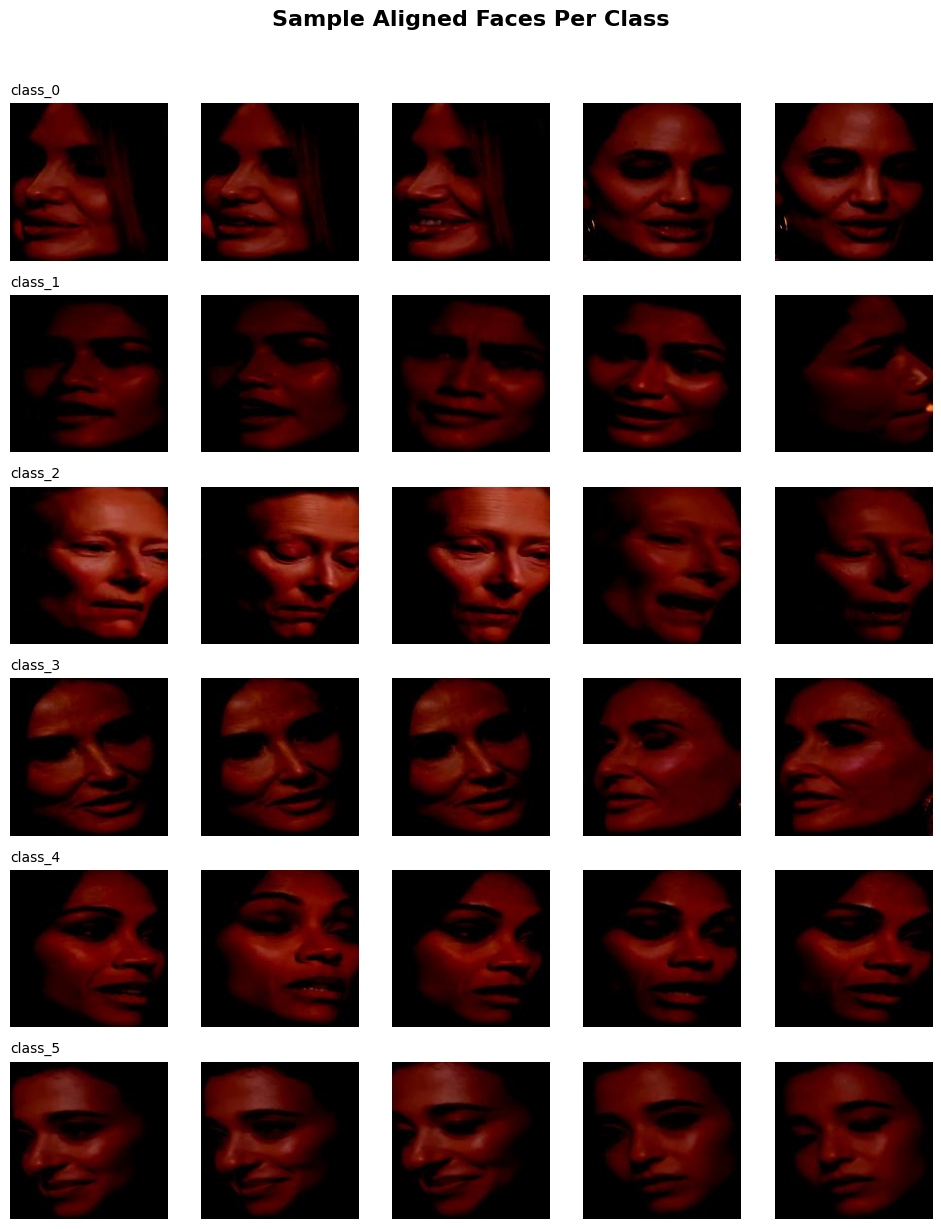

In [10]:
class_dirs = sorted(list(aligned_root.iterdir()))

# Number of classes and samples per class
num_classes = len(class_dirs)
samples_per_class = 5

# Setup grid
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))
fig.suptitle("Sample Aligned Faces Per Class", fontsize=16, weight='bold', y=1.02)
plt.subplots_adjust(hspace=0.3, wspace=0.02)

# Loop through each class folder and display 5 samples
for row_idx, class_dir in enumerate(class_dirs):
    image_paths = sorted(list(class_dir.glob("*.jpg")))
    sampled_paths = image_paths[:samples_per_class]  # take first 5 (or fewer if not enough)

    for col_idx in range(samples_per_class):
        ax = axes[row_idx, col_idx] if num_classes > 1 else axes[col_idx]

        if col_idx < len(sampled_paths):
            img = Image.open(sampled_paths[col_idx])
            ax.imshow(img)
        else:
            ax.imshow(np.ones((160, 160, 3)))  # placeholder for missing images
        
        ax.axis("off")
        if col_idx == 0:
            ax.set_title(class_dir.name, fontsize=10, loc='left')

plt.tight_layout()
plt.show();


## Step 4: Organize and Verify Dataset

We now have cropped aligned face images organized by class.
Let’s verify the number of images per class.

In [11]:
base_path = Path("aligned_faces")
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"Folder '{folder_name}' has {file_count} files.")


Folder 'class_4' has 253 files.
Folder 'class_5' has 52 files.
Folder 'class_1' has 387 files.
Folder 'class_2' has 206 files.
Folder 'class_0' has 226 files.
Folder 'class_3' has 295 files.


## Step 5: Manual Cluster Labeling (Post-Clustering Review)

After the automatic KMeans clustering, we manually reviewed each cluster and renamed the folders to the actual celebrity names. This ensures accurate labeling for each identity class.

Although the KMeans model groups similar faces well, it doesn't know the identities. Visual inspection allows us to fix any misclassified frames and apply correct names.

This is a **manual process** for now. In the future, if a verification model or ID database is integrated, this step can be automated.

After renaming, we also removed any images that were misclassified or uncertain.

The new structure in `aligned_faces/` reflects the actual names (e.g., `Angelina_Jolie`, `Zendaya`, `Demi_Moore`, etc.).


In [22]:
base_path = Path("aligned_faces")
for folder in sorted(base_path.iterdir()):
    print(f"{folder.name}: {len(list(folder.glob('*.jpg')))} images")


Angelina_Jolie: 225 images
Demi_Moore: 294 images
Mikey_Madison: 51 images
Tilda_Swinton: 205 images
Zendaya: 386 images
Zoe_Saldaña: 252 images


## Step 6: Create DataLoader and Class Mappings

We now treat each subdirectory as a class and use PyTorch’s `ImageFolder` to load and transform the images.

In [15]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder(root="aligned_faces", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}


In [16]:
idx_to_class

{0: 'Angelina_Jolie',
 1: 'Demi_Moore',
 2: 'Mikey_Madison',
 3: 'Tilda_Swinton',
 4: 'Zendaya',
 5: 'Zoe_Saldaña'}

## Step 7: Compute and Save Average Face Embeddings (Face Imprints)

We compute an **average face embedding** per class. This serves as the **unique digital signature** of a person.


In [20]:
state_dict = torch.load(local_weights_path, map_location=device)
resnet = InceptionResnetV1(classify=False, pretrained=None)
resnet.eval()
resnet = resnet.to(device)
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for batch_imgs, batch_idxs in loader:
    batch_imgs = batch_imgs.to(device)
    with torch.no_grad():
        batch_embeddings = resnet(batch_imgs)
    for emb, idx in zip(batch_embeddings, batch_idxs):
        name_to_embeddings[idx_to_class[idx.item()]].append(emb.cpu())

embeddings_to_save = {name: torch.stack(embs).mean(dim=0) for name, embs in name_to_embeddings.items()}
torch.save(embeddings_to_save, "embeddings.pt")


## Step 8: Verify Saved Embeddings

Check the contents of the saved file to confirm successful serialization.


In [21]:

loaded_embeddings = torch.load("embeddings.pt")
print(f"Saved classes: {list(loaded_embeddings.keys())}")


Saved classes: ['Angelina_Jolie', 'Demi_Moore', 'Mikey_Madison', 'Tilda_Swinton', 'Zendaya', 'Zoe_Saldaña']


## Step 9: Face Similarity Analysis Using Cosine Similarity

To understand how similar different faces are according to the FaceNet embedding model, we compute the **cosine similarity** between face embeddings of a few selected celebrities.

Cosine similarity measures the angle between two embedding vectors:
- `+1.0`: Highly similar
- `0.0`: Not similar
- `-1.0`: Completely dissimilar (opposite)

We use this metric to evaluate how similar the embedding of **Angelina Jolie** is to others, and visualize all comparisons in a heatmap.



In [25]:
# Compare two embeddings
cosine_sim = torch.nn.CosineSimilarity(dim=0)

emb0 = loaded_embeddings["Angelina_Jolie"]
emb1 = loaded_embeddings["Demi_Moore"]
emb2 = loaded_embeddings["Mikey_Madison"]
emb3 = loaded_embeddings["Tilda_Swinton"]
emb4 = loaded_embeddings["Zendaya"]
emb5 = loaded_embeddings["Zoe_Saldaña"]

print(f"Angelina vs Demi Moore     : {cosine_sim(emb0, emb1):.3f}")
print(f"Angelina vs Mikey Madison : {cosine_sim(emb0, emb2):.3f}")
print(f"Angelina vs Tilda Swinton : {cosine_sim(emb0, emb3):.3f}")
print(f"Angelina vs Zendaya       : {cosine_sim(emb0, emb4):.3f}")
print(f"Angelina vs Zoe Saldana   : {cosine_sim(emb0, emb5):.3f}")


Angelina vs Demi Moore     : 0.421
Angelina vs Mikey Madison : 0.152
Angelina vs Tilda Swinton : -0.055
Angelina vs Zendaya       : 0.231
Angelina vs Zoe Saldana   : 0.440


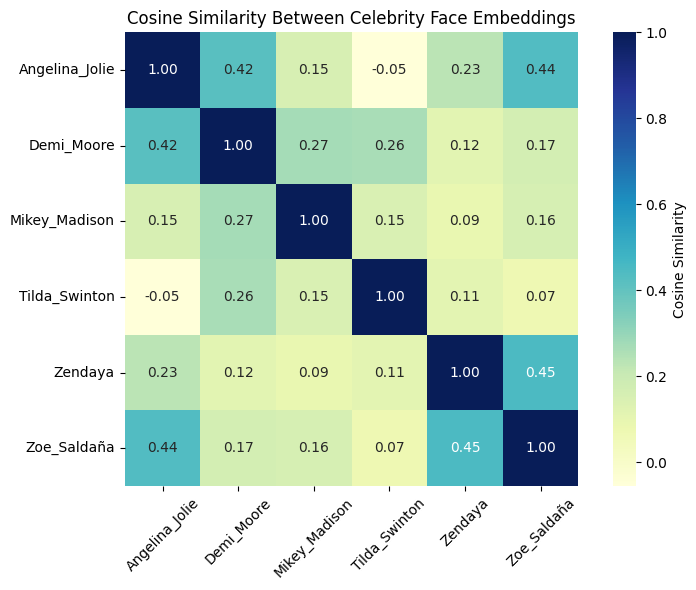

In [28]:
# Define embeddings for selected celebrities
selected_names = [
    "Angelina_Jolie",
    "Demi_Moore",
    "Mikey_Madison",
    "Tilda_Swinton",
    "Zendaya",
    "Zoe_Saldaña"
]

# Extract embeddings and stack into tensor
embeddings = torch.stack([loaded_embeddings[name] for name in selected_names])

# Normalize embeddings (optional but common before cosine similarity)
embeddings = torch.nn.functional.normalize(embeddings)

# Compute cosine similarity matrix
similarity_matrix = torch.matmul(embeddings, embeddings.T).cpu().numpy()

# Create DataFrame for visualization
df_sim = pd.DataFrame(similarity_matrix, index=selected_names, columns=selected_names)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_sim, annot=True, fmt=".2f", cmap="YlGnBu", square=True, cbar_kws={"label": "Cosine Similarity"})
plt.title("Cosine Similarity Between Celebrity Face Embeddings")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap above shows the **cosine similarity** between face embeddings of selected celebrities. 

**Key Observations:**
- **Angelina Jolie & Zoe Saldaña**: Highest similarity score (**0.44**) — this suggests their face embeddings share the most similar features among this group.
- **Angelina Jolie & Demi Moore**: Also relatively similar (**0.42**), possibly due to similar facial structure or expressions in the extracted frames.
- **Angelina Jolie & Tilda Swinton**: Lowest similarity (**-0.05**), indicating highly distinct facial features.

> Cosine similarity is especially useful in high-dimensional spaces like face embeddings, where absolute distances might be misleading.


## Step 10: Face Distance Analysis Using Euclidean Distance

While cosine similarity measures the angle between vectors, **Euclidean distance** measures the straight-line distance between two points (embeddings) in space. This gives another perspective on how "far apart" two face embeddings are.

- Smaller values mean embeddings are more similar.
- Larger values mean they are more different.

We calculate the Euclidean distances between selected celebrity face embeddings and visualize them with a heatmap.


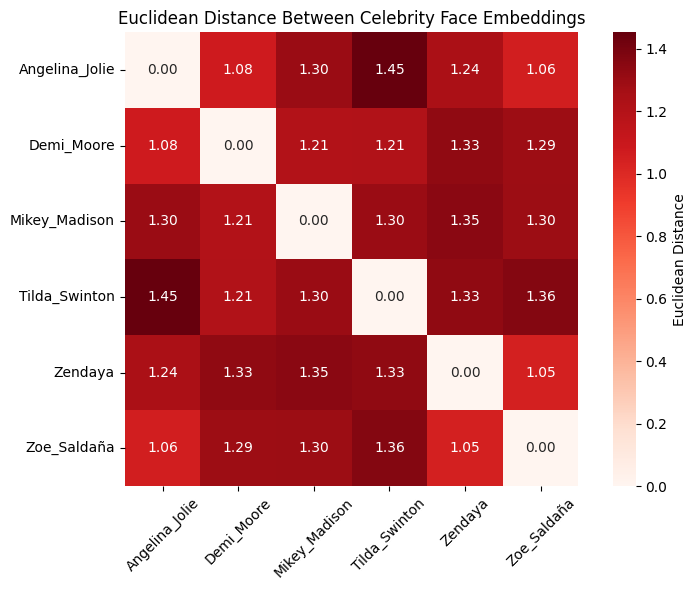

In [29]:
from scipy.spatial.distance import cdist

# Compute pairwise Euclidean distances between embeddings
# embeddings: [N, D] shape where N = number of identities
euclidean_distances = cdist(embeddings.cpu().numpy(), embeddings.cpu().numpy(), metric='euclidean')

# Create DataFrame for visualization
df_dist = pd.DataFrame(euclidean_distances, index=selected_names, columns=selected_names)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_dist, annot=True, fmt=".2f", cmap="Reds", square=True, cbar_kws={"label": "Euclidean Distance"})
plt.title("Euclidean Distance Between Celebrity Face Embeddings")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The above matrix visualizes the pairwise Euclidean distances between the average face embeddings (prototypes) of different celebrities. In simpler terms, it quantifies how "different" the faces of two celebrities are in the embedding space generated by your InceptionResnetV1 model.

**Key findings from the matrix:**

- The matrix is symmetrical about the diagonal. The distance between Angelina Jolie and Demi Moore is the same as the distance between Demi Moore and Angelina Jolie.
- Lower Euclidean distances indicate higher similarity, and vice versa.
- Tilda Swinton and Angelina Jolie show highest dissimilarity.
- Zendaya and Zoe Saldana, Angelina Jolie and Zoe Saldana show lowest dissimilarity.

## Conclusion

In this project, we developed a robust pipeline for **celebrity face recognition** using deep learning-based face embedding techniques. The core stages included:

- **Frame extraction** from video sources.
- **Face detection and filtering**, retaining only frames with a single face.
- **Face alignment** for consistent embedding extraction.
- **Clustering and labeling** of detected faces to group similar identities.
- **Embedding generation** using pre-trained models.
- **Similarity analysis** using both cosine similarity and Euclidean distance.

These steps enabled us to understand relationships between faces in a high-dimensional feature space and form a foundation for scalable face recognition systems. The visualizations helped validate our processing pipeline and highlighted the power of embeddings in measuring facial similarity.

With clean, aligned, and labeled embeddings in place, we're now ready to move toward deploying this system as a **face recognition web application**.

## Ethical Considerations

While facial recognition technology holds immense potential in security, personalization, and digital organization, it also comes with **significant ethical concerns**. As responsible practitioners, we must:

- **Respect privacy**: All images and data used in this project are for educational and demonstrative purposes. Real-world applications must comply with legal data use and consent regulations (e.g., GDPR, CCPA).
- **Avoid misuse**: This tool should not be used for surveillance, profiling, or any discriminatory purposes.
- **Ensure fairness**: Facial recognition systems can exhibit bias across gender, race, and age. Continuous auditing and diverse datasets are essential to prevent unfair outcomes.

By keeping ethics at the forefront, we can harness this technology for **positive and responsible innovation**.

